Epoch 25/250 - Loss: 0.1804
Epoch 50/250 - Loss: 0.0778
Epoch 75/250 - Loss: 0.0437
Epoch 100/250 - Loss: 0.0258
Epoch 125/250 - Loss: 0.0216
Epoch 150/250 - Loss: 0.0194
Epoch 175/250 - Loss: 0.0047
Epoch 200/250 - Loss: 0.0103
Epoch 225/250 - Loss: 0.0056
Epoch 250/250 - Loss: 0.0026

Final Performance:
Accuracy: 0.92
Precision: 0.7511
Recall: 0.5712
F1 Score: 0.618
AUROC: 0.8573


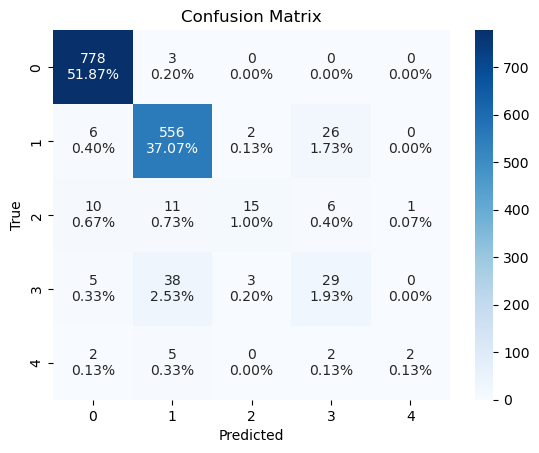

In [6]:
# --- ECG Preprocessing and Augmentation ---
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.preprocessing import StandardScaler

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    return butter(order, [low, high], btype='band')

def bandpass_filter(signal, lowcut=0.5, highcut=40.0, fs=140.0, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    return filtfilt(b, a, signal)

def extract_heartbeat(signal, fs=140, window=140):
    filtered = bandpass_filter(signal, fs=fs)
    peaks, _ = find_peaks(filtered, distance=fs//2, height=np.max(filtered) * 0.4)
    center = peaks[0] if len(peaks) > 0 else len(filtered) // 2
    start = max(0, center - window // 2)
    end = start + window
    if end > len(filtered):
        filtered = np.pad(filtered, (0, end - len(filtered)))
    return filtered[start:end]

def augment_signal(signal):
    shift = np.random.randint(-5, 6)
    noise = np.random.normal(0, 0.02, size=signal.shape)
    signal_aug = np.roll(signal, shift) + noise
    return signal_aug

def preprocess_dataset(X, y, augment=False):
    processed = []
    labels = []
    for i, x in enumerate(X):
        clean = extract_heartbeat(x)
        if augment and np.sum(y == y[i]) < 200:  # augment minority classes
            for _ in range(3):
                processed.append(augment_signal(clean))
                labels.append(y[i])
        processed.append(clean)
        labels.append(y[i])
    # Normalize
    X_std = np.array([StandardScaler().fit_transform(x.reshape(-1,1)).flatten() for x in processed])
    return X_std, np.array(labels)


# --- Load and Prepare Data ---
import pickle
from sklearn.preprocessing import LabelEncoder

with open("ECG5000_train.pickle", "rb") as f_train, open("ECG5000_validation.pickle", "rb") as f_val:
    ECGdataset = {"train": pickle.load(f_train), "val": pickle.load(f_val)}

train_data = np.array(ECGdataset["train"])
val_data = np.array(ECGdataset["val"])

X_train_raw = train_data[:, 1:]
y_train_raw = train_data[:, 0].astype(int)
X_val_raw = val_data[:, 1:]
y_val_raw = val_data[:, 0].astype(int)

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train_raw)
y_val = encoder.transform(y_val_raw)

X_train, y_train = preprocess_dataset(X_train_raw, y_train, augment=True)
X_val, y_val = preprocess_dataset(X_val_raw, y_val, augment=False)


# --- Convert to PyTorch ---
import torch
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.tensor(X_train[:, np.newaxis, :], dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val[:, np.newaxis, :], dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=20, shuffle=True)


# --- TCN Model Matching Paper ---
import torch.nn as nn

class CausalConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super().__init__()
        self.pad = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, dilation=dilation)
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = nn.functional.pad(x, (self.pad, 0))  # causal padding
        x = self.conv(x)
        x = self.bn(x)
        return self.relu(x)

class TCN(nn.Module):
    def __init__(self, input_channels=1, num_classes=5):
        super().__init__()
        self.network = nn.Sequential(
            CausalConvBlock(input_channels, 16, kernel_size=8, dilation=1),
            CausalConvBlock(16, 16, kernel_size=8, dilation=2),
            CausalConvBlock(16, 16, kernel_size=8, dilation=4),
            CausalConvBlock(16, 16, kernel_size=8, dilation=8),
        )
        self.fc = nn.Linear(16, num_classes)

    def forward(self, x):
        x = self.network(x)
        x = x.mean(dim=-1)  # global average pooling
        return self.fc(x)


# --- Training and Evaluation ---
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt

model = TCN()
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(250):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch + 1) % 25 == 0:
        print(f"Epoch {epoch+1}/250 - Loss: {total_loss/len(train_loader):.4f}")

# --- Evaluation ---
model.eval()
with torch.no_grad():
    logits = model(X_val_tensor)
    y_pred = torch.argmax(logits, dim=1).numpy()
    y_prob = torch.softmax(logits, dim=1).numpy()

acc = round(accuracy_score(y_val, y_pred), 4)
prec = round(precision_score(y_val, y_pred, average='macro', zero_division=0), 4)
rec = round(recall_score(y_val, y_pred, average='macro', zero_division=0), 4)
f1 = round(f1_score(y_val, y_pred, average='macro', zero_division=0), 4)
auroc = round(roc_auc_score(label_binarize(y_val, classes=np.unique(y_train)), y_prob, average='macro', multi_class='ovr'), 4)

print("\nFinal Performance:")
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1)
print("AUROC:", auroc)

cf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(dpi=100)
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
labels = np.asarray(labels).reshape(cf_matrix.shape)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

torch.save(model.state_dict(), "tcn_model.pt")